# Fitting with $cov(x_i,y_i) \neq 0$

The idea is to use orthogonal distance regression, with a linear fit. The $\chi^2$ function will use a matrix product with the inverse covariance matrix in it, for each pair $x_i, y_i$.

First we come up with a simple test case. The underlying rule is a two-piece linear function.

In [167]:
import numpy as np
import matplotlib.pyplot as plt

slope1 = 0.5
slope2 = 1.5
x_connect = 5

def f1(x):
    return slope1 * x

def f2(x):
    return f1(x_connect) + slope2 * (x - x_connect)

def f(x):
    return np.where(x < 5, f1(x), f2(x))
    

The base data are 5 points below and 5 above the slope change. We will give these points some random deviations, with the lower points having correlated xy, and the upper points not. The error bars do not need to be correct to test the method, I just want to see of the behaviour of the ODR fitting is expected.

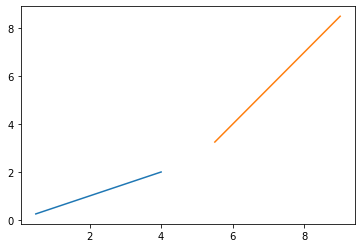

In [168]:
x_lo = np.array([0.5, 1.5, 2, 3.5, 4])
x_hi = np.array([5.5, 6, 6.3, 7, 9])
x = np.concatenate((x_lo, x_hi))

y_lo = f(x_lo)
y_hi = f(x_hi)
y = np.concatenate((y_lo, y_hi))

plt.plot(x_lo, y_lo)
plt.plot(x_hi, y_hi)

In [174]:
# function to plot covariance matrices
from scipy.linalg import eigh
def cov_ellipse(x, y, cov, num_sigma=1):
    # length^2 and orientation of ellipse axes is determined by eigenvalues and vectors, respectively
    # eigh is more stable for symmetric / hermitian matrices
    values, vectors = eigh(cov)
    
    width, height = np.sqrt(values) * num_sigma
    orientation = vectors[:, 0]
    
    angle = np.arctan2(orientation[1], orientation[0])
  
    return patches.Ellipse([x,y], width=width, height=height, angle=angle * 180 / np.pi, 
                    facecolor=(.1,.1,.1,.2), edgecolor='k')

def draw_ellipses(ax, xs, ys, covs, num_sigma=1):
    for x, y, cov in zip(xs, ys, covs):
        ax.add_patch(cov_ellipse(x, y, cov, num_sigma))
        
def plot_scatter_with_ellipses(xs, ys, covs, num_sigma=1):
    plt.scatter(xs, ys, marker='.')
    draw_ellipses(plt.gca(), xs, ys, covs, num_sigma=num_sigma)

Now the plan is to do two tests where the lower points use the correlated matrices, while the upper ones only use the neutral covariance. One test will use the negative xy correlation, the other positive. We then expect to see a difference in the fitting result, and we will try to understand it and see if the ODR method performs as expected.

But first, let's add some random noise to the points to make sure that the fitting method does not freak out about the points being on a perfect line. Even though we have different covariance matrices, we will still use the same noise. We're only interested in the effect of the covariance matrices on the result for a FIXED set of points.

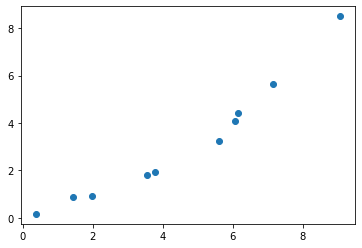

In [175]:
data_x = x + np.random.normal(scale=0.1, size=10)
data_y = y + np.random.normal(scale=0.1, size=10)

plt.scatter(data_x, data_y)

# set up some fictional covariance matrices: one anticorrelated, one correlated, one neutral
factor = 10
cov_n = np.array([[0.02, -0.02], [-0.02, 0.04]]) * factor
cov_p = np.array([[0.02, +0.02], [+0.02, 0.04]]) * factor
cov_0 = np.array([[0.03, 0], [0, 0.03]]) * factor

## Fitting method from Hogg et al. (2010)
Hogg et al. (2010) show how to get the orthogonal distance, as wel as the variance in that direction. This results in an equation for the log likelihood $\log \mathcal{L}$. I maximize it here using the default maximizer of scipy. Error estimates are derived from the inverse Hessian of $
\log \mathcal{L}$, see "minimum variance bound" in certain statistics courses". I might do a more empirical error estimation later to make sure this error estimation is suitable.


In [200]:
import math
from scipy import optimize

def perp(m):
    return np.array([-m, 1]) / math.sqrt(1 + m*m)

def deltas(xy, m, b):
    v = perp(m)
    return xy.dot(v) - b * v[1]
    
def sigmas(covs, m):
    v = perp(m)
    return np.einsum('i,kij,j->k', v, covs, v)

def logL(m, b, xy):
    return -0.5 * np.square(deltas(xy, m, b) / sigmas(covs, m)).sum()

def to_minimize(v):
    m = v[0]
    b = v[1]
    return -logL(m, b, xy)

def linear_ortho_maxlh(data_x, data_y, cov_xy):
    # put the coordinates in pairs, to use the equations of Hogg et al. 2010
    xy = np.column_stack((data_x, data_y))
    
    res = optimize.minimize(to_minimize, (1,1))
    m, b = res.x
    sigma_m, sigma_b = np.sqrt(np.diag(res.hess_inv))
    rho_mb = res.hess_inv[0,1] / (sigma_m * sigma_b)
    print(res)
    print("mx + b,", m, b)
    print("err, err, rho:", sigma_m, sigma_b, rho_mb)
    return m, b, sigma_m, sigma_b, rho_mb

## Test 1: positive cov

In [201]:
# set covs for lo and hi points separately
covs = np.zeros((len(data_x), 2, 2))
covs[:5] = cov_p
covs[5:] = cov_0

      fun: 27.6596850612562
 hess_inv: array([[ 0.00070758, -0.00220256],
       [-0.00220256,  0.01138485]])
      jac: array([-9.53674316e-07, -2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([ 0.78563627, -0.53906014])
mx + b, 0.7856362745410701 -0.5390601424830812
err, err, rho: 0.026600298109630445 0.10669981086695086 -0.7760292324254827


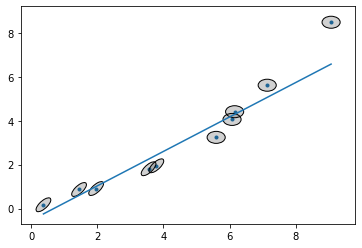

In [203]:
x_fun = np.linspace(min(data_x), max(data_x), 100)
plot_scatter_with_ellipses(data_x, data_y, covs, num_sigma=1)

m, b, sigma_m, sigma_b, rho_mb = linear_ortho_maxlh(data_x, data_y, covs)
plt.plot(x_fun, m * x_fun + b)

## Test 2: negative cov 

      fun: 8.172814044890472
 hess_inv: array([[ 0.00437118, -0.0242212 ],
       [-0.0242212 ,  0.16071345]])
      jac: array([-1.43051147e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([ 1.00198458, -1.50222008])
mx + b, 1.0019845763472226 -1.5022200791352434
err, err, rho: 0.06611490904501173 0.40089081549616096 -0.9138398783780959


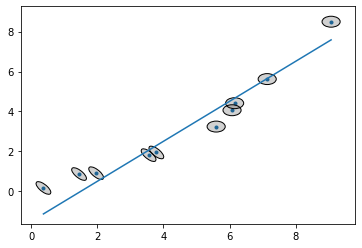

In [204]:
covs = np.zeros((len(data_x), 2, 2))
covs[:5] = cov_n
covs[5:] = cov_0
plot_scatter_with_ellipses(data_x, data_y, covs, num_sigma=1)
m, b, sigma_m, sigma_b, rho_mb = linear_ortho_maxlh(data_x, data_y, covs)
plt.plot(x_fun, m * x_fun + b)

## Test ellipse plotting

In [110]:
# benchmark by eye agains 2D normal
cov_n = np.array([[1, +.01],[+.01,.01]])
points = np.random.multivariate_normal([0,0], cov_n, size=2000)

0 0 (3.000151495870351+0j) (0.2984811582443689+0j) 0.5786665340647588


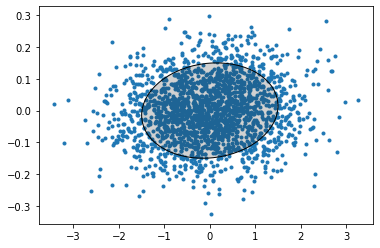

In [117]:
plt.scatter(points[:,0], points[:,1], marker='.')
plt.gca().add_patch(cov_ellipse(0, 0, cov_n, num_sigma=3))
plt.show()

0.031622776601683784
2.0313766530131074 1.968123190654809
0 0 4.5445668646820145 4.403057121186857 3.622496094655944


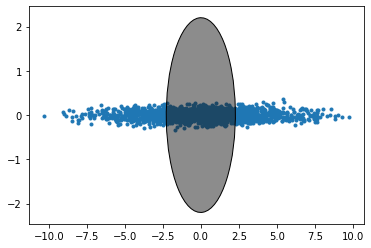

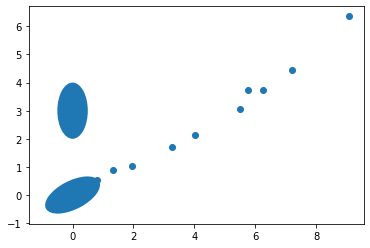

In [36]:
from matplotlib import patches
fig, ax = plt.subplots()
el1 = patches.Ellipse([0,0], 2, 1, angle=30)
el2 = patches.Ellipse([0,3], 2, 1, angle=90)
ax.add_patch(el1)
ax.add_patch(el2)
ax.scatter(data_x, data_y)